In [1]:
import corner 
from matplotlib import pyplot as plt
import torch 

import deep_tensor as dt

from examples.sir.sir import SIRModel
import examples.plotting as plotting

plt.style.use("../plotstyle.mplstyle")
torch.manual_seed(1)

In [2]:
import importlib
importlib.reload(dt)
importlib.reload(plotting)

<module 'examples.plotting' from '/Users/adeb0907/Documents/usyd/deep-tensor-py/examples/plotting.py'>

Build preconditioner.

In [3]:
model = SIRModel()
n_solves = 10_000
params = 2.0 * torch.rand((n_solves, 2))

n_samples = 2_000
xs = torch.randn((n_samples, 2))
ys = model.solve_fwd(model.gauss2unif(xs))
es = model.var_error * torch.randn_like(ys)

samples_joint = torch.hstack((ys + es, xs))
preconditioner = dt.SampleBasedPreconditioner(samples_joint)

In [4]:
ys.std(dim=0)

tensor([1.2203, 1.8197, 2.5762, 3.3775])

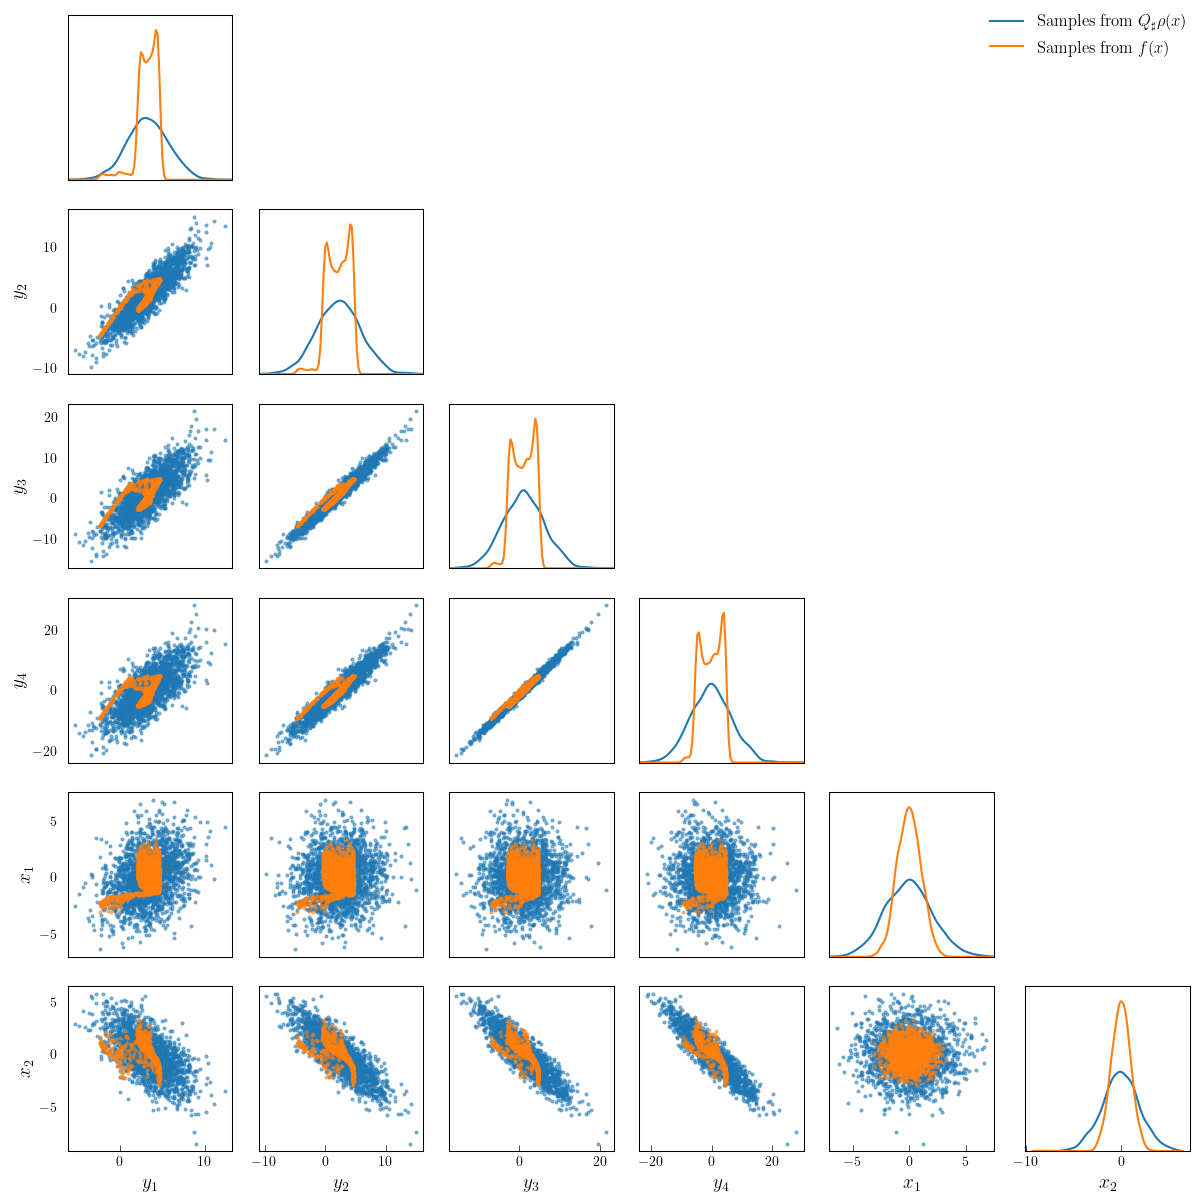

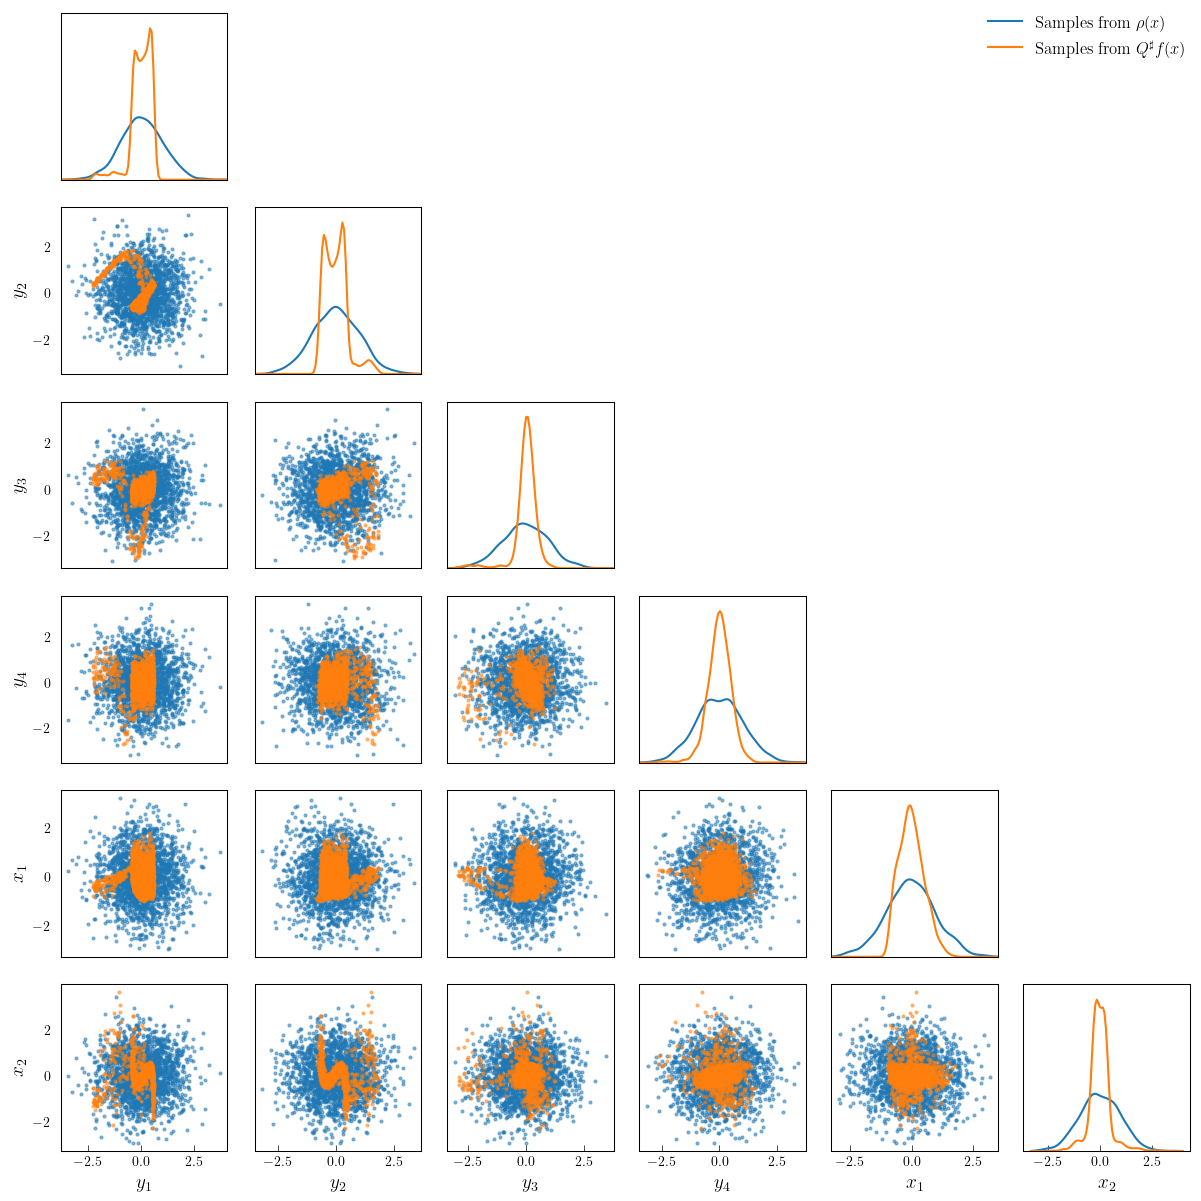

In [5]:
samples_reference = preconditioner.reference.random(d=6, n=2_000)
samples_preconditioner = preconditioner.Q(samples_reference)
samples_joint_pullback = preconditioner.Q_inv(samples_joint)

labels = [f"$y_{i+1}$" for i in range(4)] + [f"$x_{i+1}$" for i in range(2)]

plotting.corner_plot(
    xs=samples_preconditioner, 
    ys=samples_joint, 
    x_label=r"Samples from $Q_{\sharp}\rho(x)$",
    y_label=r"Samples from $f(x)$",
    labels=labels,
    fname="figures/preconditioner.pdf"
)

plotting.corner_plot(
    xs=samples_reference, 
    ys=samples_joint_pullback, 
    x_label=r"Samples from $\rho(x)$",
    y_label=r"Samples from $Q^{\sharp}f(x)$",
    labels=labels,
    fname="figures/preconditioner_pullback.pdf"
)

Build DIRT object.

In [6]:
# poly = dt.Lagrange1(num_elems=30)
poly = dt.Lagrange1(num_elems=30)
tt_options = dt.TTOptions(init_rank=20, max_rank=30, tt_method="amen")

betas = torch.tensor([1e-4]) * torch.tensor(10).sqrt() ** torch.arange(9)
# betas = betas[::2]
# betas = torch.tensor([1e-4]) * torch.tensor(10) ** (0.25 * torch.arange(17))
bridge = dt.Tempering(betas)
print(betas)
# bridge = dt.Tempering(ess_tol=0.7)

# tt_options = dt.TTOptions(max_cross=2)

dirt_options = dt.DIRTOptions(method="eratio")

dirt = dt.DIRT(
    negloglik=model.negloglik_joint, 
    neglogpri=model.neglogpri_joint, 
    preconditioner=preconditioner,
    bridge=bridge,
    bases=poly,
    tt_options=tt_options,
    # dirt_options=dirt_options
)

tensor([1.0000e-04, 3.1623e-04, 1.0000e-03, 3.1623e-03, 1.0000e-02, 3.1623e-02,
        1.0000e-01, 3.1623e-01, 1.0000e+00])
[DIRT] Iter:  1 | Cum. Fevals: 2.00e+03 | Cum. Time: 2.80e-01 s | Beta: 0.0001 | ESS: 0.9932
[ALS]  Iter | Func Evals | Max Rank | Max Local Error | Mean Local Error | Max Debug Error | Mean Debug Error
[ALS]     1 |      61690 |       22 |     1.00000e+00 |      1.00000e+00 |     7.02938e-02 |      2.36190e-02
[ALS]  TT-cross complete. Final TT ranks: [22, 22, 22, 22, 16, 1].
[DIRT] Iter:  2 | Cum. Fevals: 1.27e+05 | Cum. Time: 6.48e+00 s | Beta: 0.0003 | ESS: 0.9746 | DHell: 0.0185
[ALS]  Iter | Func Evals | Max Rank | Max Local Error | Mean Local Error | Max Debug Error | Mean Debug Error
[ALS]     1 |      68758 |       24 |     9.36795e-02 |      6.90578e-02 |     7.09861e-02 |      3.31825e-02
[ALS]  TT-cross complete. Final TT ranks: [24, 24, 24, 24, 18, 1].
[DIRT] Iter:  3 | Cum. Fevals: 2.67e+05 | Cum. Time: 1.42e+01 s | Beta: 0.0010 | ESS: 0.9192 | DHel

/Users/adeb0907/Documents/usyd/deep-tensor-py/deep_tensor/polynomials/cdf_1d.py:271: UserWarning: Regula falsi did not converge (1 unconverged samples). Maximum residual: 4.5590e-07.
  warnings.warn(msg)


[ALS]     1 |     127379 |       32 |     6.46555e-01 |      5.52185e-01 |     7.42440e-01 |      4.61812e-01
[ALS]  TT-cross complete. Final TT ranks: [31, 32, 32, 32, 30, 1].
[DIRT] Iter:  9 | Cum. Fevals: 1.60e+06 | Cum. Time: 1.42e+02 s | Beta: 1.0000 | ESS: 0.1026 | DHell: 0.3995
[ALS]  Iter | Func Evals | Max Rank | Max Local Error | Mean Local Error | Max Debug Error | Mean Debug Error


/Users/adeb0907/Documents/usyd/deep-tensor-py/deep_tensor/polynomials/cdf_1d.py:271: UserWarning: Regula falsi did not converge (2 unconverged samples). Maximum residual: 9.4388e-08.
  warnings.warn(msg)


[ALS]     1 |     128433 |       32 |     7.72023e-01 |      7.07593e-01 |     1.34402e+00 |      9.95342e-01
[ALS]  TT-cross complete. Final TT ranks: [31, 32, 32, 32, 32, 1].
[DIRT] DIRT construction complete.
[DIRT]  • Layers: 9.
[DIRT]  • Total function evaluations: 1852208.
[DIRT]  • Total time: 180.72 s.


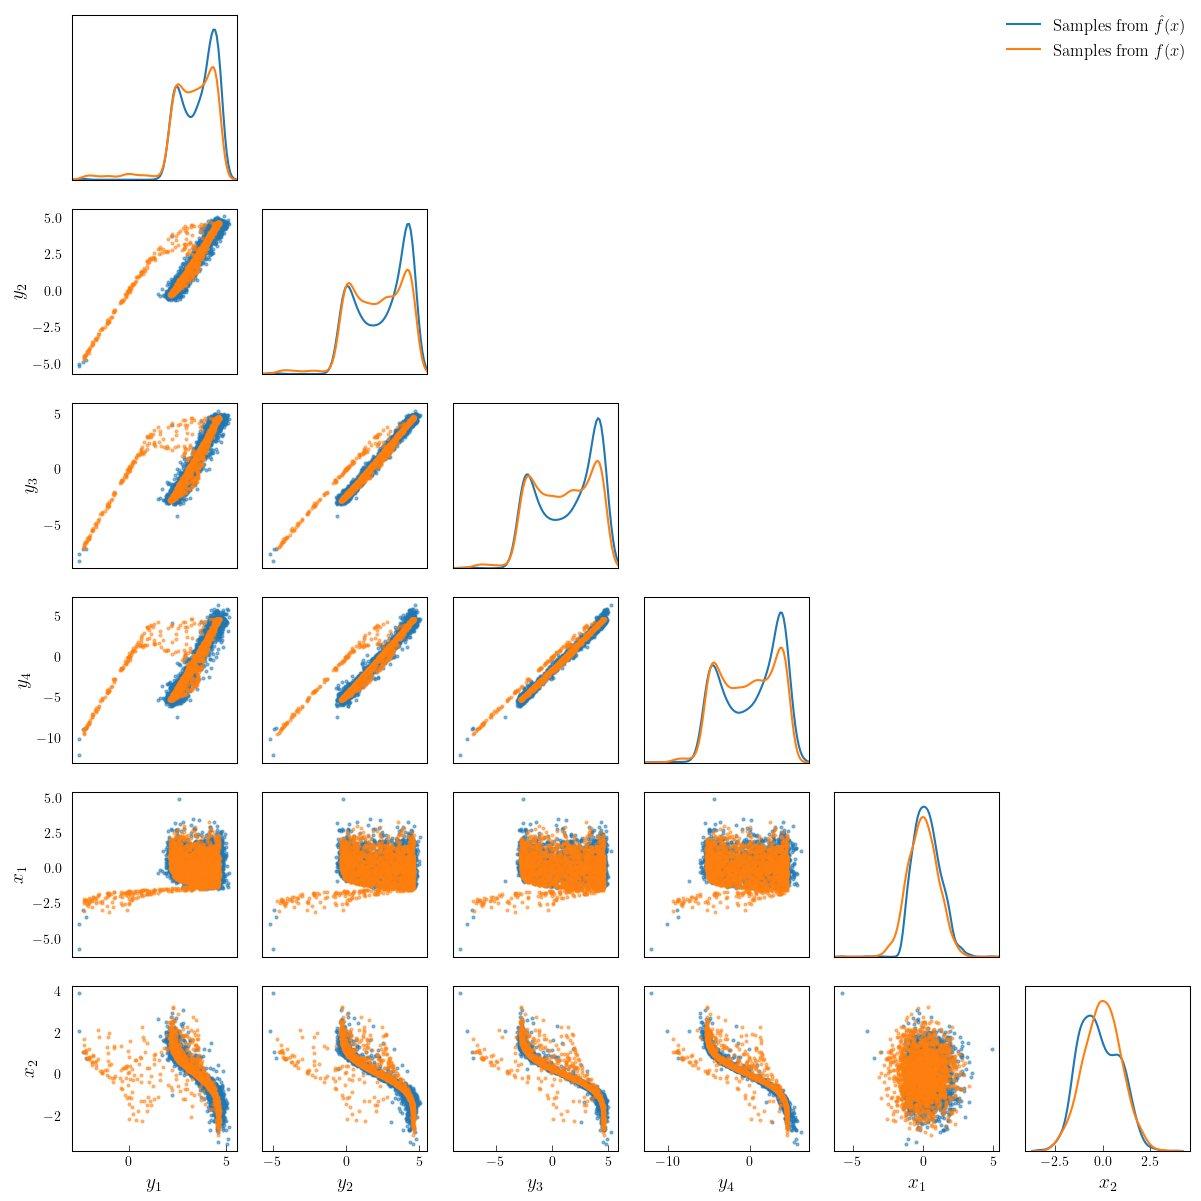

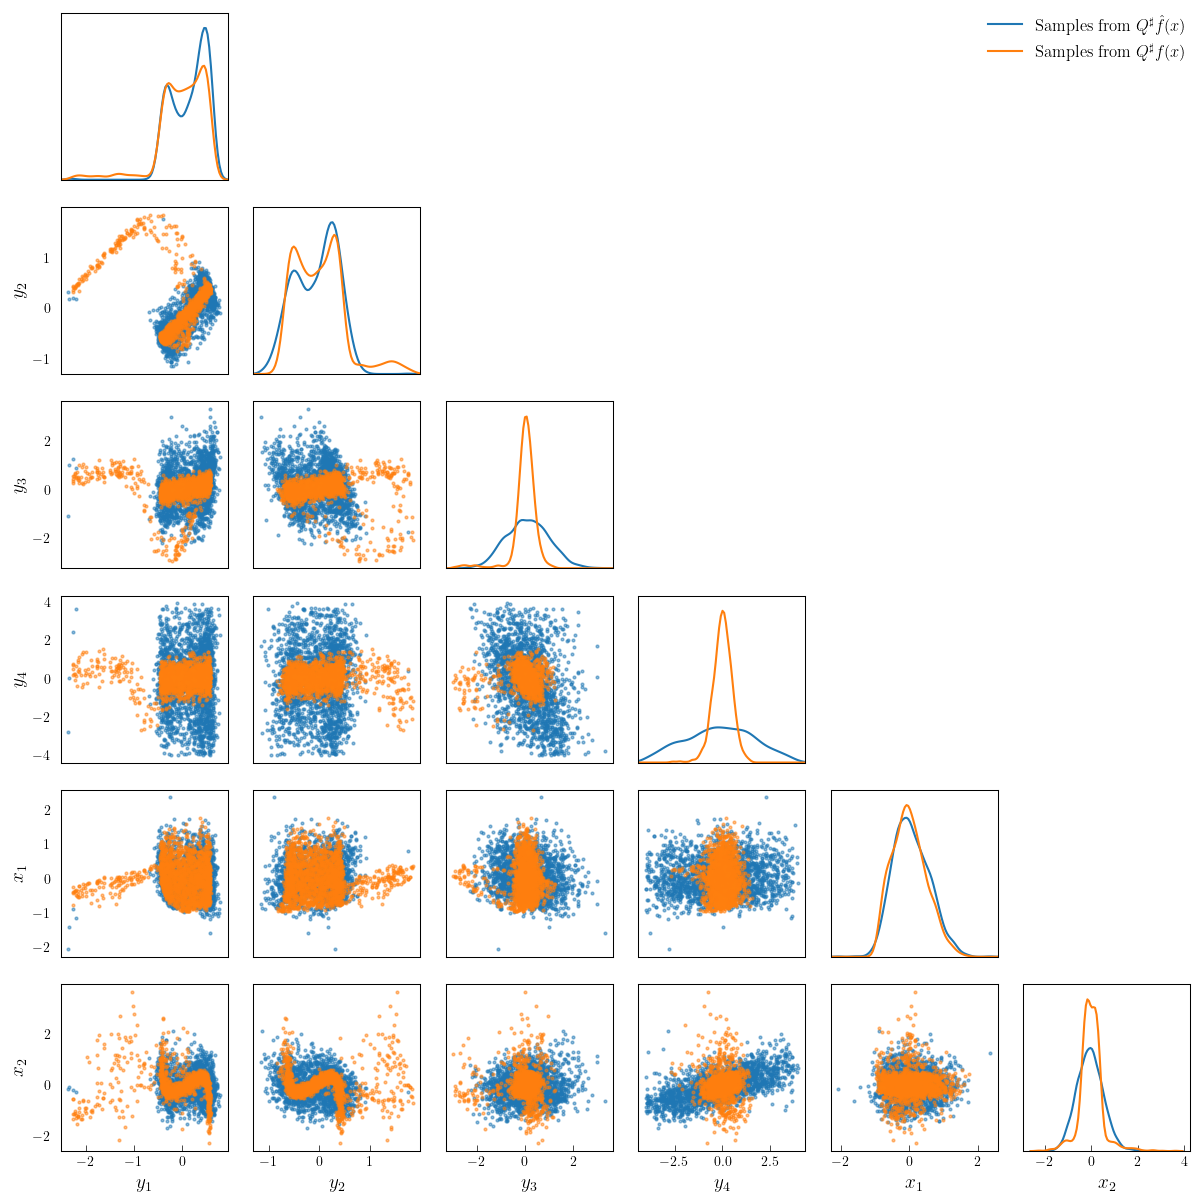

In [7]:
samples_dirt = dirt.random(2000)
samples_dirt_pullback = preconditioner.Q_inv(samples_dirt)

plotting.corner_plot(
    xs=samples_dirt, 
    ys=samples_joint, 
    x_label=r"Samples from $\hat{f}(x)$",
    y_label=r"Samples from $f(x)$",
    labels=labels,
    fname="figures/dirt.pdf"
)

plotting.corner_plot(
    xs=samples_dirt_pullback, 
    ys=samples_joint_pullback, 
    x_label=r"Samples from $Q^{\sharp}\hat{f}(x)$",
    y_label=r"Samples from $Q^{\sharp}f(x)$",
    labels=labels,
    fname="figures/dirt_pullback.pdf"
)

In [8]:
xs_test = torch.randn((10, 2))
xs_test[0] = model.unif2gauss(torch.tensor([0.1, 1.0]))
ys_test = model.solve_fwd(model.gauss2unif(xs_test))
# ys_test += model.var_error * torch.randn_like(ys_test)  # add error

# For DHell
n_rs = 50_000
rs = dirt.reference.random(d=2, n=n_rs)

In [9]:
def plot_density_comparison(xs_grid, ys_grid, fxs_true, fxs_dirt, x_true, dhell, fname):

    fig, axes = plt.subplots(
        nrows=1, ncols=2, 
        figsize=(8, 4), 
        sharex=True, sharey=True
    )
    
    axes[0].pcolormesh(xs_grid, ys_grid, fxs_true, rasterized=True)
    axes[1].pcolormesh(xs_grid, ys_grid, fxs_dirt, rasterized=True)
    axes[0].set_title(r"$f(x)$ (True)")
    axes[1].set_title(r"$\hat{f}(x)$ (DIRT)")
    axes[0].set_ylabel(r"$x_{1}$")

    for ax in axes:
        ax.scatter(*x_true, c="k", marker="x", s=5)
        ax.set_xlabel(r"$x_{0}$")

    plt.suptitle(r"$\mathcal{D}_{\mathrm{H}}$"+f": {dhell:.4f}")
    plt.savefig(fname)
    
    return

/Users/adeb0907/Documents/usyd/deep-tensor-py/deep_tensor/polynomials/basis_1d.py:224: UserWarning: 480 points are outside the domain.
  warnings.warn(msg)


0: 0.2573692637834572


/Users/adeb0907/Documents/usyd/deep-tensor-py/deep_tensor/polynomials/basis_1d.py:224: UserWarning: 2009 points are outside the domain.
  warnings.warn(msg)
/Users/adeb0907/Documents/usyd/deep-tensor-py/deep_tensor/polynomials/cdf_1d.py:271: UserWarning: Regula falsi did not converge (5 unconverged samples). Maximum residual: 8.6929e-08.
  warnings.warn(msg)
/Users/adeb0907/Documents/usyd/deep-tensor-py/deep_tensor/polynomials/cdf_1d.py:271: UserWarning: Regula falsi did not converge (4 unconverged samples). Maximum residual: 1.1849e-06.
  warnings.warn(msg)


1: 0.9361392814021698


/Users/adeb0907/Documents/usyd/deep-tensor-py/deep_tensor/polynomials/basis_1d.py:224: UserWarning: 578 points are outside the domain.
  warnings.warn(msg)


2: 0.112449611018386


/Users/adeb0907/Documents/usyd/deep-tensor-py/deep_tensor/polynomials/basis_1d.py:224: UserWarning: 935 points are outside the domain.
  warnings.warn(msg)


3: 0.17012901604402764


/Users/adeb0907/Documents/usyd/deep-tensor-py/deep_tensor/polynomials/basis_1d.py:224: UserWarning: 2154 points are outside the domain.
  warnings.warn(msg)
/Users/adeb0907/Documents/usyd/deep-tensor-py/deep_tensor/polynomials/cdf_1d.py:271: UserWarning: Regula falsi did not converge (1 unconverged samples). Maximum residual: 2.1016e-07.
  warnings.warn(msg)


4: 0.18378687347788464


/Users/adeb0907/Documents/usyd/deep-tensor-py/deep_tensor/polynomials/basis_1d.py:224: UserWarning: 752 points are outside the domain.
  warnings.warn(msg)


5: 0.16109026797208847


/Users/adeb0907/Documents/usyd/deep-tensor-py/deep_tensor/polynomials/basis_1d.py:224: UserWarning: 2055 points are outside the domain.
  warnings.warn(msg)


6: 0.2410605115713986


/Users/adeb0907/Documents/usyd/deep-tensor-py/deep_tensor/polynomials/basis_1d.py:224: UserWarning: 1054 points are outside the domain.
  warnings.warn(msg)


7: 0.16342168929324558


/Users/adeb0907/Documents/usyd/deep-tensor-py/deep_tensor/polynomials/basis_1d.py:224: UserWarning: 2459 points are outside the domain.
  warnings.warn(msg)


8: 0.34917548076267085


/Users/adeb0907/Documents/usyd/deep-tensor-py/deep_tensor/polynomials/basis_1d.py:224: UserWarning: 2251 points are outside the domain.
  warnings.warn(msg)


9: 0.22830525088659928


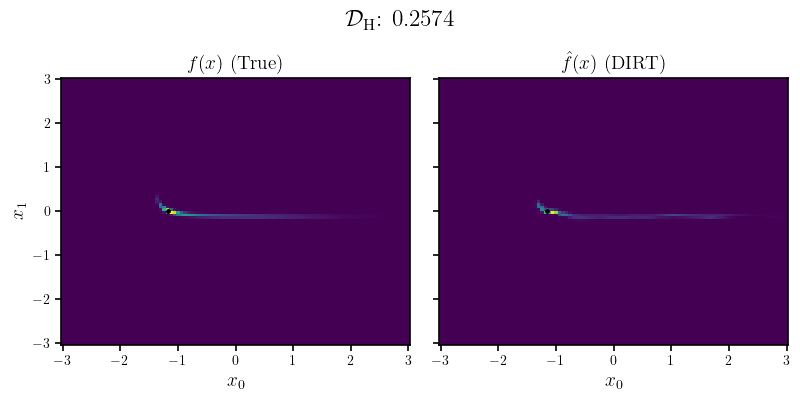

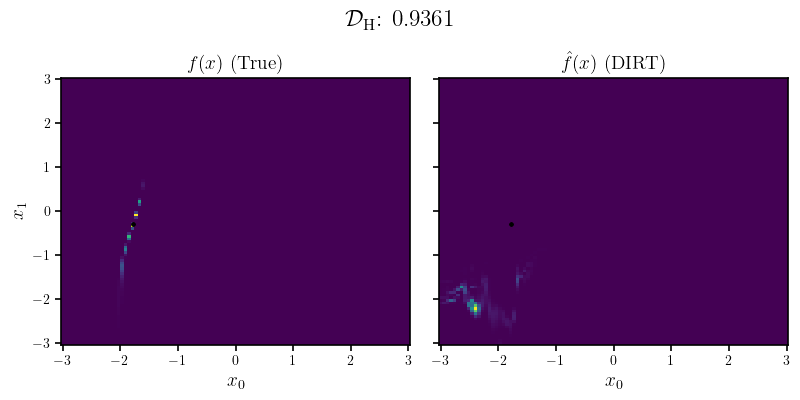

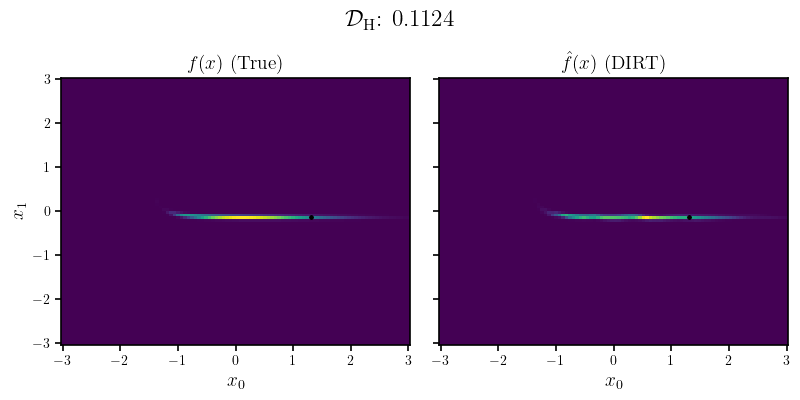

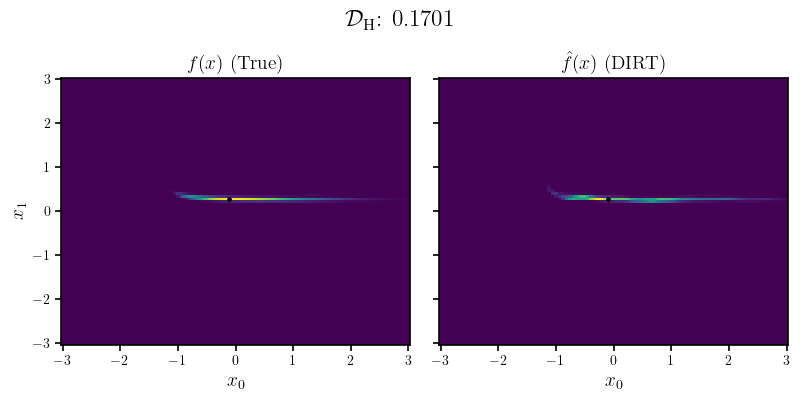

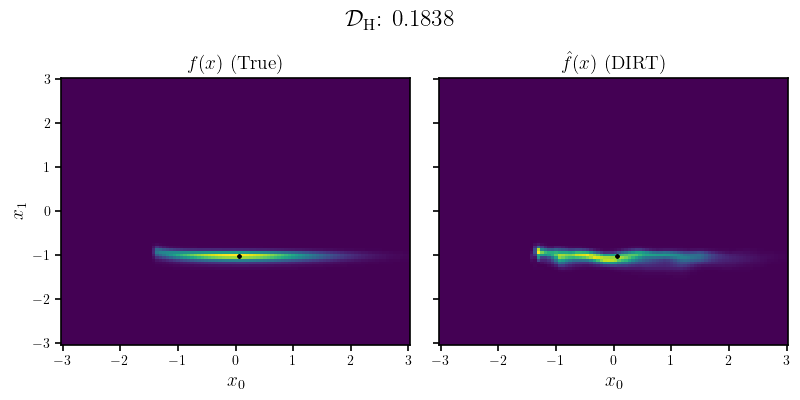

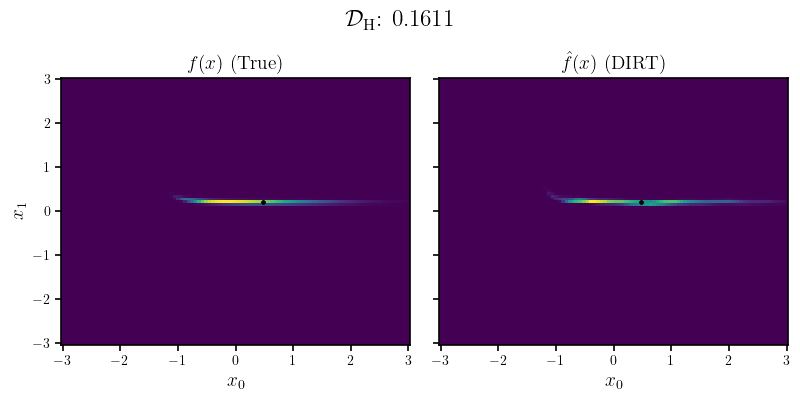

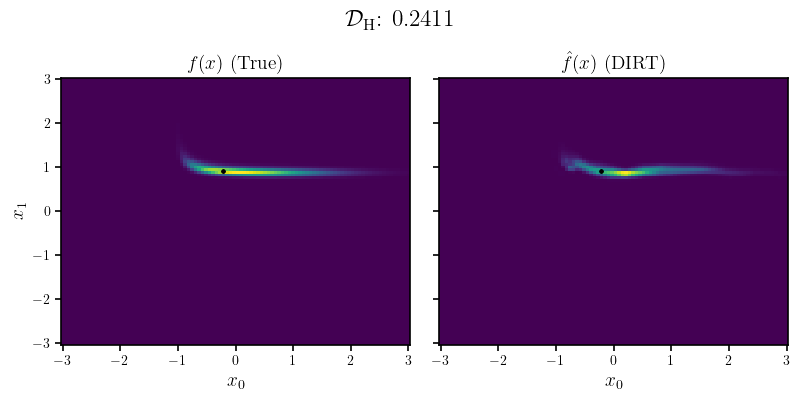

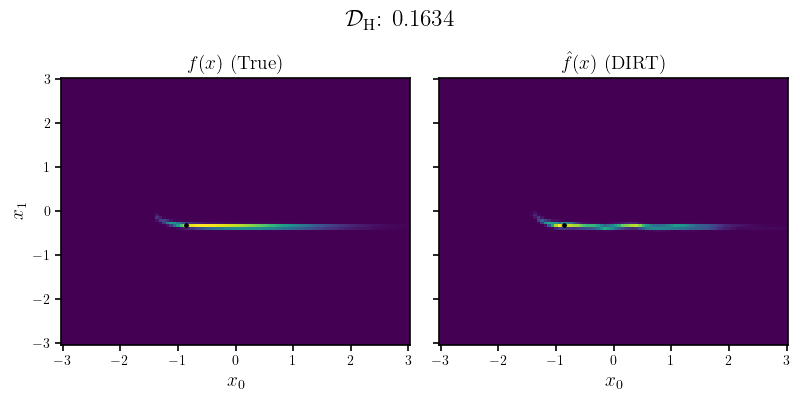

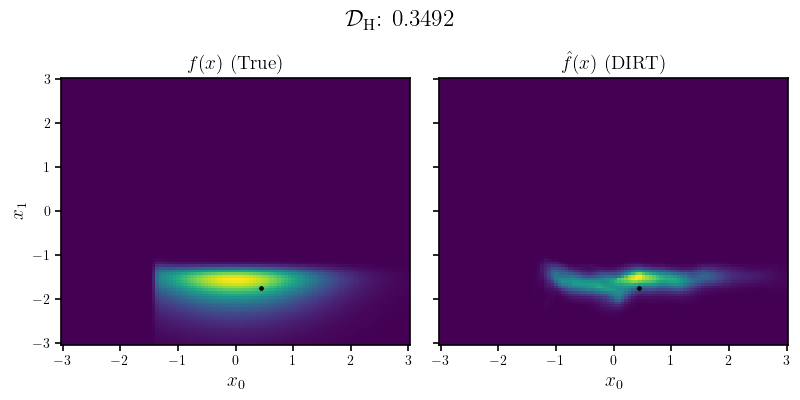

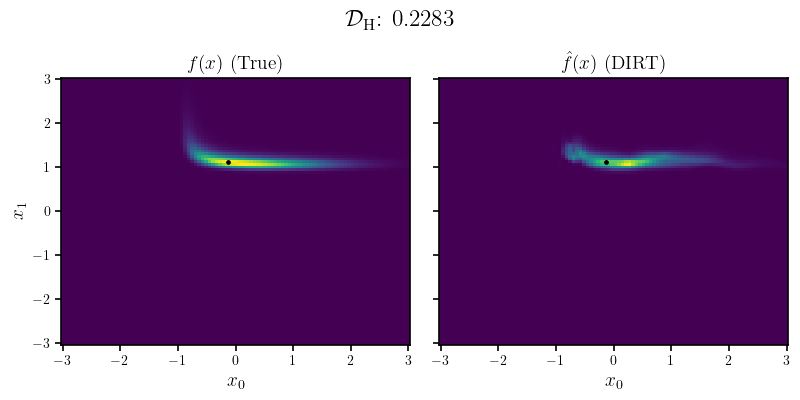

In [10]:
n_grid = 100

for i, y_i in enumerate(ys_test):

    if i == -1:
        xs_grid = torch.linspace(-1.4, -0.9, n_grid)
        ys_grid = torch.linspace(-0.5, 0.5, n_grid)
    else:
        xs_grid = torch.linspace(-3.0, 3.0, n_grid)
        ys_grid = torch.linspace(-3.0, 3.0, n_grid)

    dx = xs_grid[1] - xs_grid[0]
    grid = torch.tensor([[x, y] for y in ys_grid for x in xs_grid])

    y_is = y_i.repeat(n_grid**2, 1)
    yx_is = torch.hstack((y_is, grid))

    # Evaluate true conditional density on grid
    neglogfxs_true = model.potential_joint(yx_is)
    fxs_true = torch.exp(-neglogfxs_true) / (neglogfxs_true.sum() * dx**2)
    fxs_true = fxs_true.reshape(n_grid, n_grid)

    # Evaluate CIRT density on grid
    neglogfxs_ys = dirt.eval_potential(y_is)
    rs_grid, neglogfxs_grid = dirt.eval_rt(torch.hstack((y_is, grid)))
    neglogfxs_dirt = neglogfxs_grid - neglogfxs_ys
    fxs_dirt = torch.exp(-neglogfxs_dirt).reshape(n_grid, n_grid)

    # Estimate Hellinger distance
    xs, neglogfxs_dirt = dirt.eval_cirt(y_i, rs)
    yxs = torch.hstack((y_i.repeat(n_rs, 1), xs))
    neglogfxs_true = model.potential_joint(yxs)

    dhell2 = dt.compute_f_divergence(-neglogfxs_dirt, -neglogfxs_true, div="h2")
    dhell = dhell2.sqrt()
    print(f"{i}: {dhell}")

    plot_density_comparison(
        xs_grid, 
        ys_grid, 
        fxs_true, 
        fxs_dirt, 
        xs_test[i], 
        dhell=dhell, 
        fname=f"figures/posterior_{i}.pdf"
    )